In [1]:
import os
from pathlib import Path
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
BASE_DIR = Path.cwd().parent
os.chdir(BASE_DIR)

DATA = BASE_DIR / "data" / "smsspam_dataset.csv"
BASE = BASE_DIR / "results"

print("Diretório base:", BASE_DIR)
print("DATA existe:", DATA.exists())
print("RESULTS existe:", BASE.exists())

Diretório base: /home/corisco/llm-spam-benchmark
DATA existe: True
RESULTS existe: True


In [3]:
df_gt = pd.read_csv(DATA)
df_gt = df_gt[["id", "label"]].copy()
df_gt["label"] = df_gt["label"].str.strip().str.lower()

print(f"Dataset carregado: {len(df_gt)} exemplos.")

Dataset carregado: 5160 exemplos.


In [4]:
models = [p.name for p in BASE.iterdir() if p.is_dir()]
print("Modelos encontrados:", models)

Modelos encontrados: ['gpt-4.1-mini', 'gpt-3.5-turbo-0125', 'gpt-5-nano', 'gpt-5-mini', 'gpt-4o-mini', 'gpt-4.1']


In [5]:
results = []

for model in models:
    pred_path = BASE / model / "predictions.csv"
    if not pred_path.exists():
        print(f"{model}: arquivo predictions.csv não encontrado.")
        continue

    df_pred = pd.read_csv(pred_path)
    df_pred["prediction"] = df_pred["prediction"].str.strip().str.lower()
    df_merged = df_gt.merge(df_pred, on="id", how="inner")

    # Filtra apenas classes válidas
    df_merged = df_merged[df_merged["prediction"].isin(["ham", "spam"])]
    df_merged = df_merged[df_merged["label"].isin(["ham", "spam"])]

    if df_merged.empty:
        print(f"{model}: sem amostras válidas após filtragem.")
        continue

    y_true = df_merged["label"]
    y_pred = df_merged["prediction"]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label="spam", zero_division=0)
    rec  = recall_score(y_true, y_pred, pos_label="spam", zero_division=0)
    f1   = f1_score(y_true, y_pred, pos_label="spam", zero_division=0)
    mcc  = matthews_corrcoef(y_true, y_pred)

    # Taxa de falsos positivos (Blocked Hams)
    cm = confusion_matrix(y_true, y_pred, labels=["ham", "spam"])
    tn, fp, fn, tp = cm.ravel()
    bh = fp / (fp + tn) if (fp + tn) > 0 else 0

    results.append({
        "model": model,
        "samples": len(df_merged),
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "bh": bh,
        "mcc": mcc
    })

In [6]:
df_results = pd.DataFrame(results)
df_results[["accuracy","precision","recall","f1","bh","mcc"]] *= 100  # percentage
df_results = df_results.round(2)
display(df_results.sort_values("f1", ascending=False))

,model,samples,accuracy,precision,recall,f1,bh,mcc
5,gpt-4.1,5160,98.68,93.09,96.57,94.80,1.02,94.07
0,gpt-4.1-mini,5160,98.20,89.73,96.57,93.02,1.57,92.07
3,gpt-5-mini,5055,98.18,92.20,93.36,92.78,1.13,91.74
2,gpt-5-nano,5160,97.38,85.16,95.64,90.10,2.37,88.79
1,gpt-3.5-turbo-0125,5157,95.58,74.58,97.82,84.64,4.74,83.14
4,gpt-4o-mini,5160,95.29,73.17,98.13,83.83,5.11,82.34


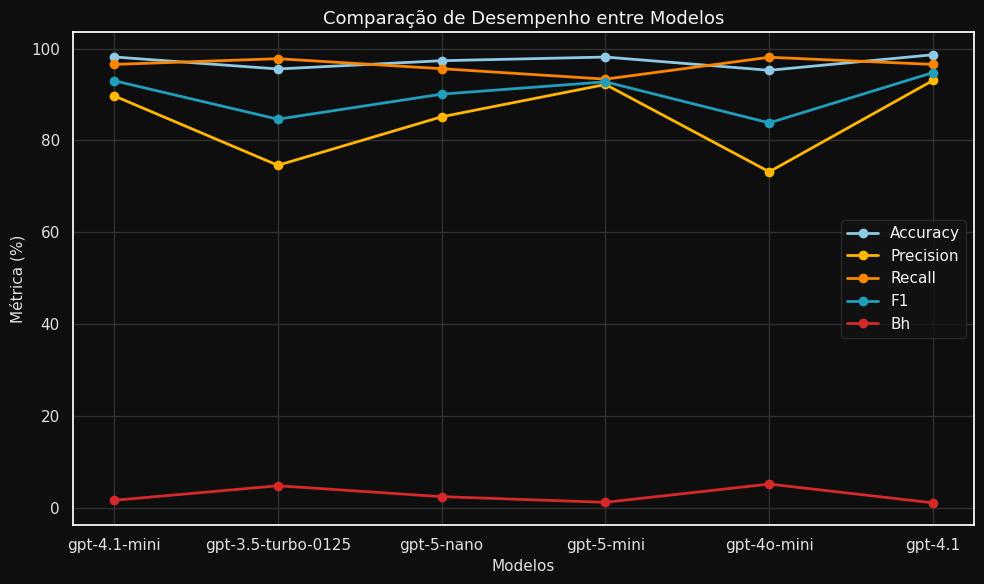

In [7]:

# === Preparação dos dados ===
df_results = pd.DataFrame(results).copy()
for col in ["accuracy","precision","recall","f1","bh"]:
    df_results[col] = df_results[col] * 100

# === Tema escuro ===
sns.set_theme(style="darkgrid", rc={
    "axes.facecolor": "#0e0e0e",
    "figure.facecolor": "#0e0e0e",
    "text.color": "#e0e0e0",
    "axes.labelcolor": "#e0e0e0",
    "xtick.color": "#e0e0e0",
    "ytick.color": "#e0e0e0",
    "grid.color": "#303030"
})

plt.figure(figsize=(10,6))
palette = {
    "accuracy":"#8ecae6",
    "precision":"#ffb703",
    "recall":"#fb8500",
    "f1":"#219ebc",
    "bh":"#d62828"
}

for metric, color in palette.items():
    plt.plot(df_results["model"], df_results[metric],
             marker="o", linewidth=2, color=color, label=metric.capitalize())

plt.title("Comparação de Desempenho entre Modelos", fontsize=13, color="#f5f5f5")
plt.xlabel("Modelos", fontsize=11)
plt.ylabel("Métrica (%)", fontsize=11)
plt.legend(facecolor="#121212", edgecolor="#303030", labelcolor="#f5f5f5")
plt.tight_layout()
plt.show()


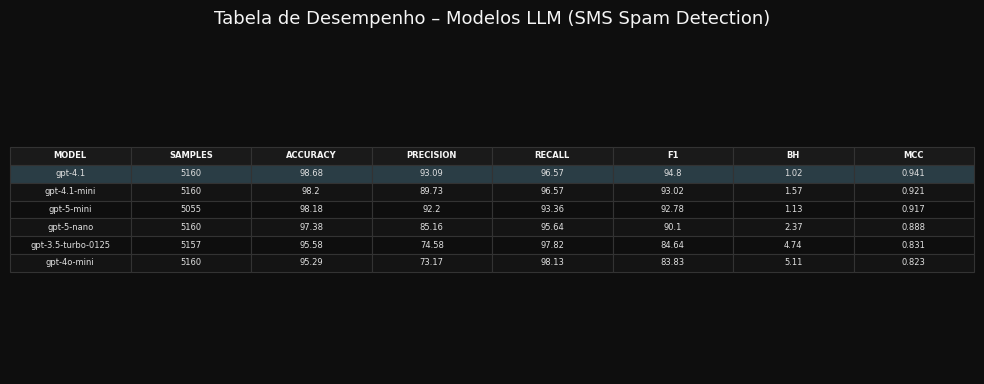

In [8]:
# === Preparação dos dados ===
df_results = pd.DataFrame(results).copy()
for col in ["accuracy", "precision", "recall", "f1", "bh"]:
    df_results[col] = (df_results[col] * 100).round(2)
df_results["mcc"] = df_results["mcc"].round(3)

# Ordena por F1 Score
df_results = df_results.sort_values(by="f1", ascending=False)
cols_order = ["model", "samples", "accuracy", "precision", "recall", "f1", "bh", "mcc"]
df_results = df_results[cols_order]

# === Estilo da figura ===
fig, ax = plt.subplots(figsize=(10, len(df_results) * 0.5 + 1))
fig.patch.set_facecolor("#0e0e0e")
ax.set_facecolor("#0e0e0e")
ax.axis("off")

# === Criação da tabela ===
table = ax.table(
    cellText=df_results.values,
    colLabels=[c.upper() for c in df_results.columns],
    cellLoc="center",
    colLoc="center",
    loc="center"
)

# === Tema escuro e ajustes visuais ===
for key, cell in table.get_celld().items():
    cell.set_edgecolor("#333333")
    cell.set_linewidth(0.8)
    cell.set_fontsize(9)
    cell.set_text_props(color="#e0e0e0")

# Cabeçalhos
for j in range(len(df_results.columns)):
    table[0, j].set_facecolor("#1a1a1a")
    table[0, j].set_text_props(weight="bold", color="#f5f5f5")

# Linhas alternadas
for i in range(1, len(df_results) + 1):
    bg = "#141414" if i % 2 == 0 else "#0e0e0e"
    for j in range(len(df_results.columns)):
        table[i, j].set_facecolor(bg)

# Realce do melhor modelo
best_idx = df_results["f1"].idxmax()
best_row = df_results.index.get_loc(best_idx) + 1
for j in range(len(df_results.columns)):
    table[best_row, j].set_facecolor("#2a3d45")

plt.title("Tabela de Desempenho – Modelos LLM (SMS Spam Detection)", color="#f5f5f5", fontsize=13, pad=15)
plt.tight_layout()
plt.show()
